<a href="https://colab.research.google.com/github/mlimbuu/pytorch-GAT/blob/main/Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
# Choose a layout
def plot_graph(G):
  pos = nx.spring_layout(G)  # Positions nodes using Fruchterman-Reingold force-directed algorithm

  # Draw the graph
  nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='k', node_size=700, font_size=16, font_color='darkred')
  plt.title('Graph Visualization')
  plt.show()

In [3]:
def plot_in_degree_distribution(G):
  # Alternatively, if you already have a NetworkX graph, you can skip the conversion.
  in_degrees = dict(G.in_degree())  # Returns a dictionary node: in-degree

  # Prepare the data for plotting
  nodes = list(G.nodes())
  in_values = [in_degrees[node] for node in nodes]

  # Plotting
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.bar(nodes, in_values, color='b')
  plt.title('In-Degree Distribution')
  plt.xlabel('Node ID')
  plt.ylabel('In-Degree Count')

  plt.tight_layout()
  plt.show()

def plot_out_degree_distribution(G):

  out_degrees = dict(G.out_degree())  # Returns a dictionary node: out-degree

  # Prepare the data for plotting
  nodes = list(G.nodes())
  out_values = [out_degrees[node] for node in nodes]

  # Plotting
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 2)
  plt.bar(nodes, out_values, color='r')
  plt.title('Out-Degree Distribution')
  plt.xlabel('Node ID')
  plt.ylabel('Out-Degree Count')

  plt.tight_layout()
  plt.show()



# Random Graph Data 1
Note: If graph is asymmetric make it symmetric before plotting in-out degree distribution.

In [4]:
# Example: Creating a sparse CSR matrix for demonstration
data = np.ones(5)
rows = np.array([0, 1, 2, 3, 4])
cols = np.array([1, 2, 3, 4, 0])
adj_matrix = csr_matrix((data, (rows, cols)), shape=(5, 5))

# Check if the matrix is symmetric
is_symmetric = np.allclose(adj_matrix.toarray(), adj_matrix.T.toarray())
print("The matrix is symmetric:", is_symmetric)

adj_matrix = adj_matrix + adj_matrix.T.multiply(adj_matrix.T > adj_matrix) - adj_matrix.multiply(adj_matrix.T > adj_matrix)
# Check if the updated matrix is symmetric
is_symmetric = np.allclose(adj_matrix.toarray(), adj_matrix.T.toarray())
print("The updated matrix is symmetric:", is_symmetric)

The matrix is symmetric: False
The updated matrix is symmetric: True


In [5]:
# Convert CSR matrix to a NetworkX graph
G = nx.from_scipy_sparse_array(adj_matrix, create_using=nx.DiGraph())

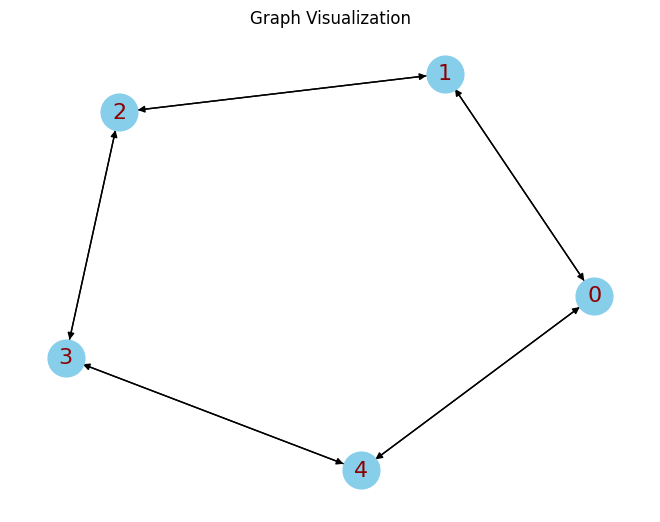

In [6]:
# Plot Graph
plot_graph(G)

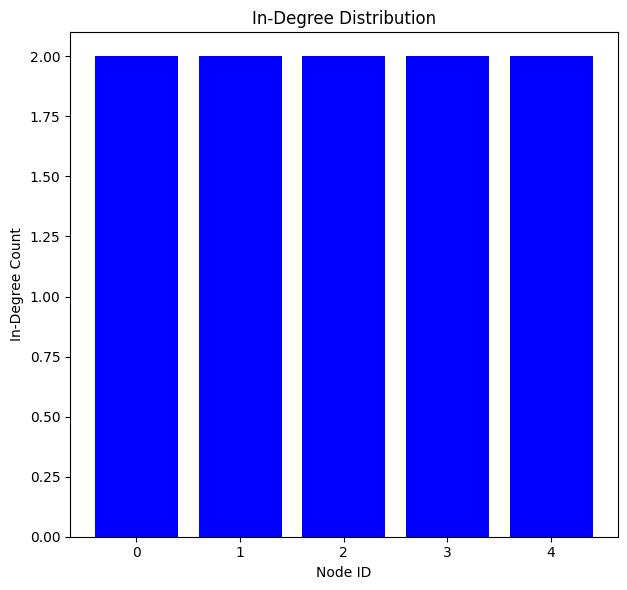

In [7]:
# Plot in and out degree distribution
plot_in_degree_distribution(G)

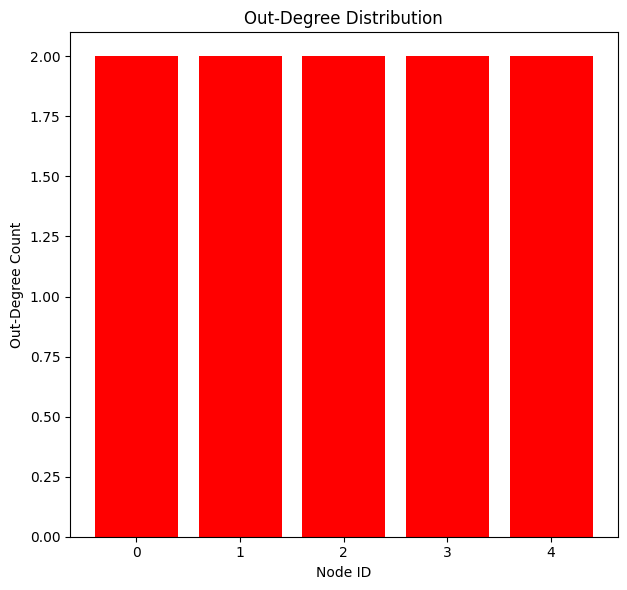

In [8]:
# Plot in and out degree distribution
plot_out_degree_distribution(G)

# Random Graph Data 2
Note: If graph is asymmetric make it symmetric before plotting in-out degree distribution.

In [9]:
# Create a random sparse matrix
data = np.random.rand(200)  # 100 non-zero items
rows = np.random.randint(0, 2708, size=200)  # Random row indices for non-zero items
cols = np.random.randint(0, 2708, size=200)  # Random column indices for non-zero items

# Create the sparse matrix
sparse_matrix = csr_matrix((data, (rows, cols)), shape=(2708, 2708), dtype=np.float32)

# Check if the matrix is symmetric
is_symmetric = np.allclose(sparse_matrix.toarray(), sparse_matrix.T.toarray())
print("The matrix is symmetric:", is_symmetric)

sparse_matrix = sparse_matrix + sparse_matrix.T.multiply(sparse_matrix.T > sparse_matrix) - sparse_matrix.multiply(sparse_matrix.T > sparse_matrix)
# Check if the updated matrix is symmetric
is_symmetric = np.allclose(sparse_matrix.toarray(), sparse_matrix.T.toarray())
print("The updated matrix is symmetric:", is_symmetric)

The matrix is symmetric: False
The updated matrix is symmetric: True


In [10]:
# Convert CSR matrix to a NetworkX graph
G = nx.from_scipy_sparse_array(sparse_matrix, create_using=nx.DiGraph())

In [11]:
# # Plot Graph
# plot_graph(G)

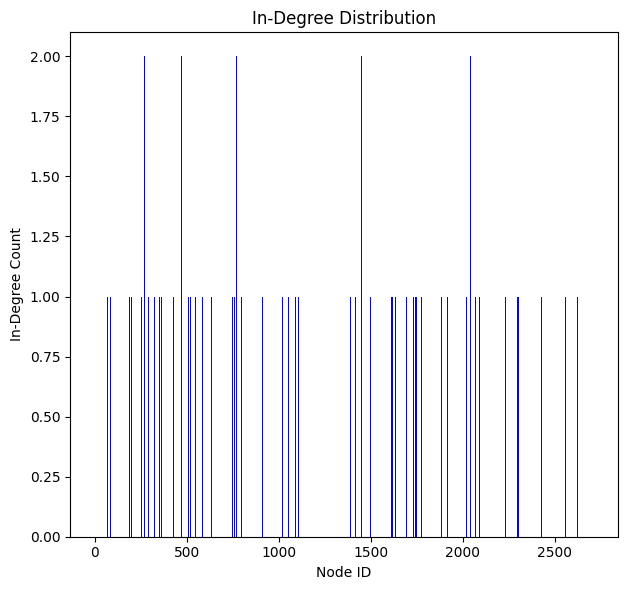

In [12]:
# Plot in degree distribution
plot_in_degree_distribution(G)

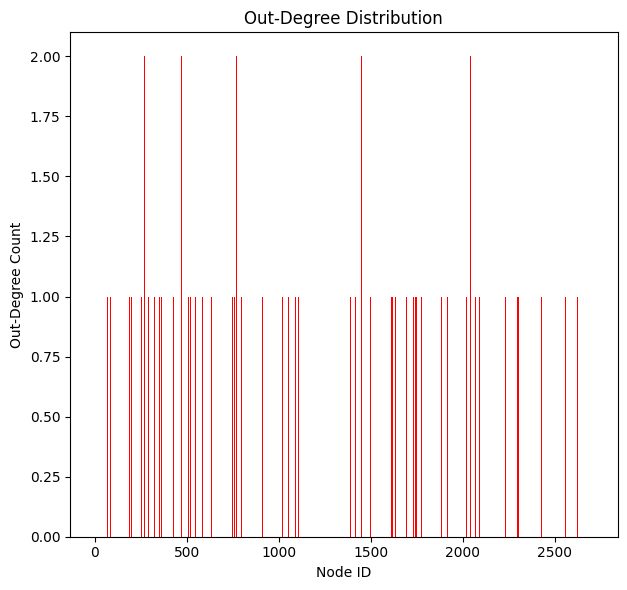

In [13]:
# Plot out degree distribution
plot_out_degree_distribution(G)

# Cora Dataset
Note: Load the data, preprocess and plot it finally. Make sure it is symmetric.

In [66]:
import scipy.sparse as sp
import zipfile
import torch
from sklearn.manifold import TSNE

In [67]:
def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx
    
def encode_onehot(labels):
    # The classes must be sorted before encoding to enable static class encoding.
    # In other words, make sure the first class always maps to index 0.
    classes = sorted(list(set(labels)))
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot
    

In [68]:


def load_data(path="./data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)


    # build symmetric adjacency matrix
    sym_adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return sym_adj
     

In [69]:
# load the preprocessed cora data

adj = load_data()

Loading cora dataset...


## In and Out Degree Distribution

In [70]:
# Convert CSR matrix to a NetworkX graph
G = nx.from_scipy_sparse_array(adj, create_using=nx.DiGraph())

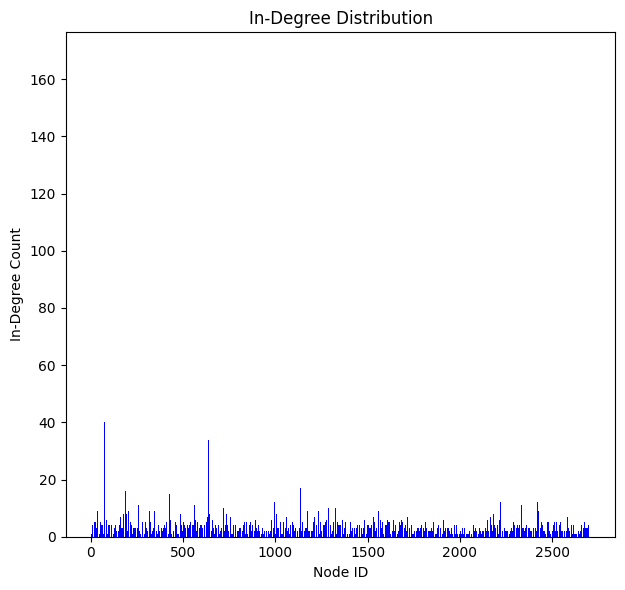

In [71]:
# Plot in degree distribution
plot_in_degree_distribution(G)

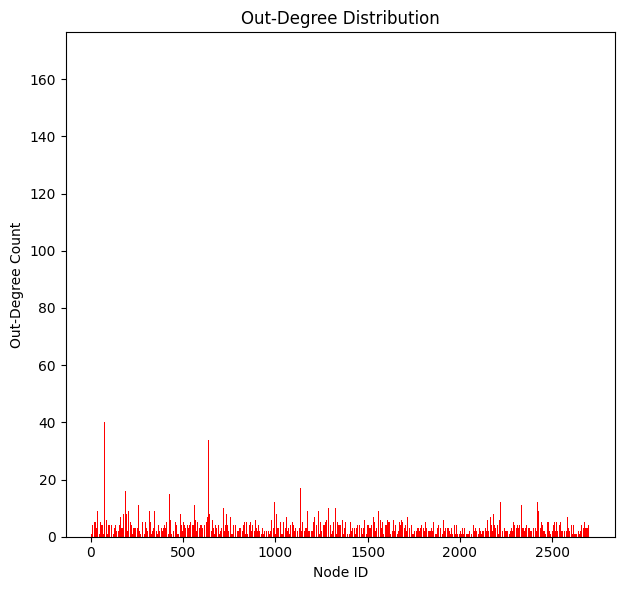

In [72]:
# Plot out degree distribution
plot_out_degree_distribution(G)

## Graph Data Visualization using TSNE

In [73]:
def load_data(path="./data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # normalize features and adjacency matrix
    features = normalize_features(features)
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    adj = torch.FloatTensor(np.array(adj.todense()))
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test


In [89]:
# visualize feature representation
def visualize_unlearnedFeature_tSNE(labels, out_features, dataset):
    color_map = {0: "red", 1: "blue", 2: "green",
                           3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    if dataset =='citeseer':
        num_classes = 6
    elif dataset == 'cora':
        num_classes = 7
        class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']  # Update as per actual names

    elif dataset =='pubmed':
        num_classes = 3
    node_labels = labels.cpu().numpy()
    out_features = out_features.cpu().detach().numpy()
    t_sne_X = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_X[node_labels == class_id, 0],
                    t_sne_X[node_labels == class_id, 1], s=20,
                    color=color_map[class_id],
                    edgecolors='black', linewidths=0.15, label=class_names[class_id])

    plt.axis("off")
    plt.legend()
    plt.title("t-SNE projection of the un-learned features for "+dataset)
    plt.show()

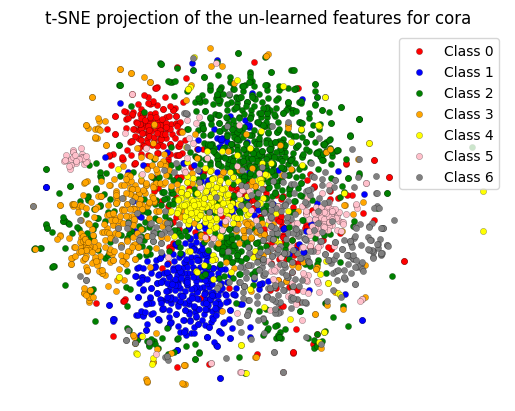

In [90]:
dataset = 'cora'
visualize_unlearnedFeature_tSNE(labels, features, dataset)

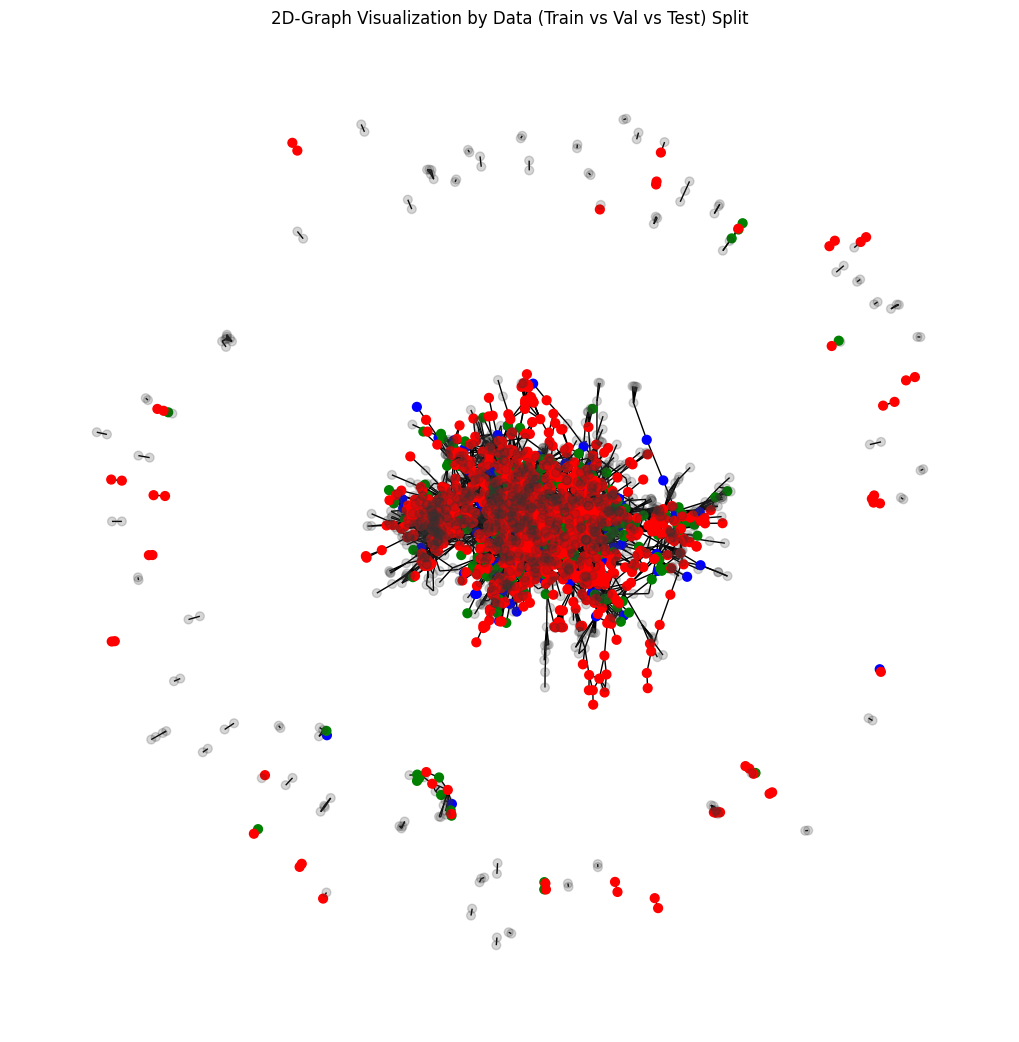

In [107]:
# Convert the adjacency matrix to a NetworkX graph
G = nx.from_numpy_array(adj)

# Define node colors based on their data split
color_map = []
for node in G:
    if node in idx_train:
        color_map.append('blue')  # Blue for training nodes
    elif node in idx_val:
        color_map.append('green')  # Green for validation nodes
    elif node in idx_test:
        color_map.append('red')  # Red for test nodes
    else:
        # color_map.append('gray')  #Gray for rest nodes
        color_map.append((0.2, 0.2, 0.2, 0.2))  # Gray with 20% transparency

plt.figure(figsize=(10, 10))
nx.draw(G, node_color=color_map, with_labels=False, node_size=40)
plt.title('2D-Graph Visualization by Data (Train vs Val vs Test) Split')
plt.show()


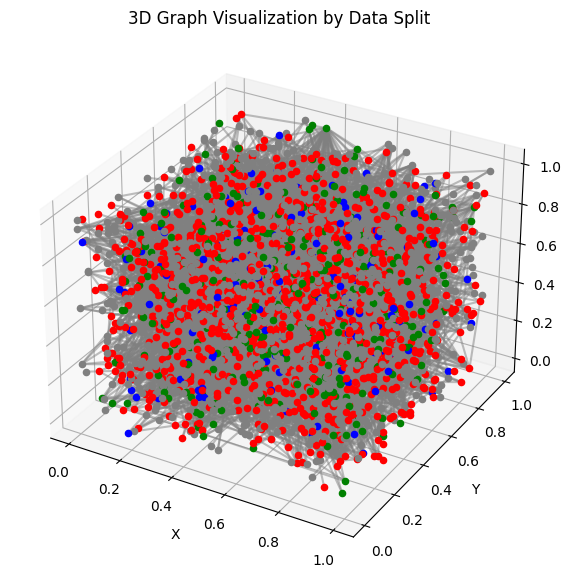

In [109]:
G = nx.from_numpy_array(adj)

# Generate random 3D positions for each node
pos = {i: (np.random.uniform(), np.random.uniform(), np.random.uniform()) for i in range(len(G))}

# Define node colors based on their data split
color_map = ['blue' if node in idx_train else 'green' if node in idx_val else 'red' if node in idx_test else 'gray' for node in G]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the nodes and the edges
for edge in G.edges():
    xs, ys, zs = zip(*[pos[edge[0]], pos[edge[1]]])
    ax.plot(xs, ys, zs, "gray", alpha=0.5)  # Draw edges

for node in pos:
    ax.scatter(*pos[node], color=color_map[node], s=20)  # Draw nodes

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Graph Visualization by Data Split')
plt.show()

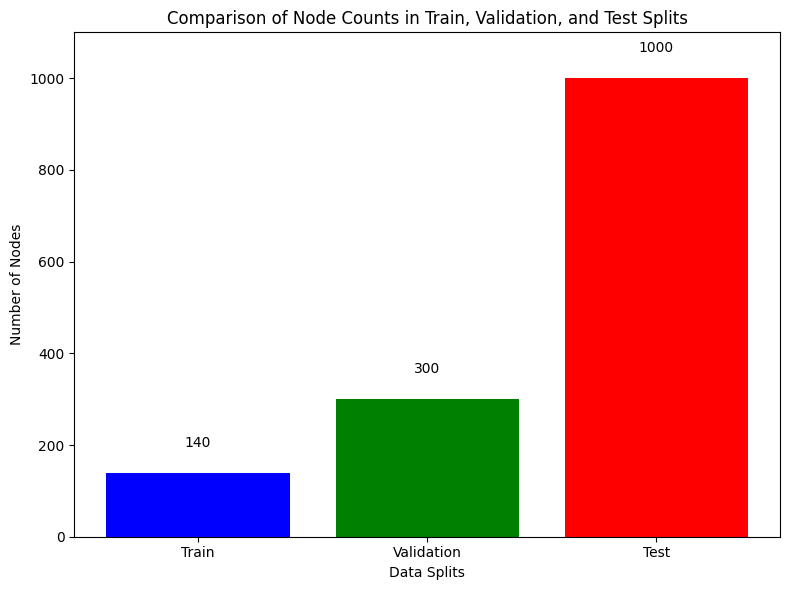

In [114]:
import matplotlib.pyplot as plt

# Assuming idx_train, idx_val, and idx_test are defined and are lists or arrays of indices
num_train = len(idx_train)
num_val = len(idx_val)
num_test = len(idx_test)

# Data to plot
labels = ['Train', 'Validation', 'Test']
counts = [num_train, num_val, num_test]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'green', 'red'])
plt.xlabel('Data Splits')
plt.ylabel('Number of Nodes')
plt.title('Comparison of Node Counts in Train, Validation, and Test Splits')
plt.ylim(0, max(counts) + int(0.1 * max(counts)))  # Set y-axis limit to make sure labels fit

# Adding the text labels on the bars
for i in range(len(labels)):
    plt.text(i, counts[i] + 0.05 * max(counts), str(counts[i]), ha = 'center', va = 'bottom')

plt.tight_layout()
plt.show()